# Time Series Forecasting with SoaM

In this notebook we will show how to make predictions and persist them using SoaM Forcaster.

In [4]:
import io

from soam.models import SkProphet
from soam.utilities.utils import add_future_dates
import matplotlib.pyplot as plt
from muttlib.dbconn import PgClient
import pandas as pd

from soam.cfg import get_db_cred
from soam.workflow.forecaster import Forecaster
from soam.savers import CSVSaver, DBSaver, Saver
from soam.plotting.forecast_plotter import ForecastPlotterTask
from soam.reporting.mail_report import MailReport
from prefect.utilities.debug import raise_on_exception
from prefect import Flow, Task, context, task
from soam.core.runner import SoamFlow
# from soam.slack_report import SlackReport

import datetime

In [2]:
# NBVAL_SKIP

saver_data = CSVSaver("/tmp/soam_data/")
# saver_runs = CSVSaver("/tmp/soam_run/")
db_cred = get_db_cred("../../soam/settings.ini")
db = PgClient(**db_cred)
saver_runs = DBSaver(db)

In [3]:
# NBVAL_SKIP

my_model = SkProphet(weekly_seasonality=False, daily_seasonality=False)
forecaster = Forecaster(my_model, savers=[saver_runs])

@task()
def read_csv_data(path: str)-> pd.DataFrame :
    print(context["date"])
    return add_future_dates(pd.read_csv(path), output_length=7)

@task()
def print_csv_data(predictions: pd.DataFrame):
        print(predictions)
    # return pd.read_csv(path) 

@task
def store_preds(saver: CSVSaver, predictions: pd.DataFrame):
    saver.save_forecaster_impl(predictions, 4)

@task
def print_model(model: SkProphet):
    print(model)

url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"

In [4]:
# NBVAL_SKIP

now = datetime.datetime.today()
with SoamFlow(name="test", saver= saver_runs) as f:
    f.start_datetime = now
    f.end_datetime = now
    df = read_csv_data(path=url)
    preds_model = forecaster(time_series=df)
    print_model(preds_model[1])

with raise_on_exception(): 
     f.run()

[2020-08-31 19:49:18] INFO - prefect.FlowRunner | Beginning Flow run for 'test'
[2020-08-31 19:49:18] INFO - prefect.TaskRunner | Task 'read_csv_data': Starting task run...
2020-08-31T19:49:18.244433+00:00
[2020-08-31 19:49:18] INFO - prefect.TaskRunner | Task 'read_csv_data': finished task run for task with final state: 'Success'
[2020-08-31 19:49:18] INFO - prefect.TaskRunner | Task 'Forecaster': Starting task run...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[2020-08-31 19:49:22] INFO - prefect.TaskRunner | Task 'Forecaster': finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'Forecaster': finished task run for task with final state: 'Success'
[2020-08-31 19:49:22] INFO - prefect.TaskRunner | Task 'GetItem': Starting task run...
INFO:prefect.TaskRunner:Task 'GetItem': Starting task run...
[2020-08-31 19:49:22] INFO - prefect.TaskRunner | Task 'GetItem': finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'GetI

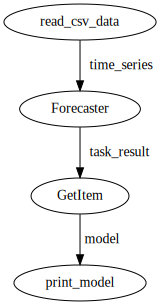

In [5]:
# NBVAL_SKIP

f.visualize()